This code produces an EMG dataset according to the methodology described by Haufe et al. in "EEG potentials predict upcoming emergency brakings during simulated driving." dx.doi.org/10.1088/1741-2560/8/5/056001. Instead of the original modeling approach, we train and test our own model here for all test subjects from the Haufe et al. study. 

The original EMG data are part of a dataset from Haufe et al. called "Emergency braking during simulated driving." The dataset is available at http://bnci-horizon-2020.eu/database/data-sets

We'll iterate through all the test subject data files to create our train and validation datasets.

In [1]:
from scipy.signal import spectrogram
from statistics import mean

#Create training data from braking event EMG via these steps:
#Get segments of braking event EMG.
#Covert to PSD.
#Store PSD components of each segment in variable for training.
def createDatasetFromEMGEvents(timestamps, data, samplingRate, numberOfPSDComponents = 4):
    dt = 1/samplingRate #Time increment in seconds
    
    dt1_index = 0
    dt2_index = int(100/1000/dt) #Covert timestamps to seconds and divde by time increment to get index of datapoint at 100 ms.
    baselineCorrection_emg = mean(data[dt1_index:dt2_index+1])
    
    #Define variables to split data in first 1/2 for training and second 1/2 for validation
    brakingEvent_emg_PSD_train = []
    brakingEvent_emg_PSD_val = []

    dt = 1/samplingRate #Time increment in seconds

    for time in timestamps: #Iterate through event timestamps in milliseconds
        #index = int(time/1000/dt) #Covert timestamps to seconds and divde by time increment to get index of datapoint
        dt1_index = int((time-300)/1000/dt) #Index of datapoint 300 ms before event datapoint.
        dt2_index = int((time+1200)/1000/dt) #Index of datapoint 1200 ms after event datapoint.

        brakingEvent_emg = data[dt1_index:dt2_index+1]-baselineCorrection_emg
        #Normalize signal data WRT to max and find generate power spectral density 
        freq_data, time_data, pwr_spectral_density_data = spectrogram(
                                                            np.array([brakingEvent_emg]),
                                                            samplingRate
                                                            )
        if time < len(data)*1000*dt/2:
            brakingEvent_emg_PSD_train.append(np.sort(np.sum(pwr_spectral_density_data[0],1))[-numberOfPSDComponents:None].tolist())
            continue
        brakingEvent_emg_PSD_val.append(np.sort(np.sum(pwr_spectral_density_data[0],1))[-numberOfPSDComponents:None].tolist())
    return brakingEvent_emg_PSD_train, brakingEvent_emg_PSD_val

In [2]:
#Create baseline training EMG data containing no braking event EMG via these steps:
#Get 100 ms EMG segment at beginning of data to use for baseline correction.
#Get segments of EMG without braking events and subract 100 ms EMG segment.
#Covert to PSD.
#Store PSD components of each segment in variable for training.

def createDatasetFromEMGWithoutEvents(timestamps, data, samplingRate, numberOfPSDComponents=4):
    dt = 1/samplingRate #Time increment in seconds
    
    dt1_index = 0
    dt2_index = int(100/1000/dt) #Covert timestamps to seconds and divde by time increment to get index of datapoint at 100 ms.
    baselineCorrection_emg = mean(data[dt1_index:dt2_index+1])

    noEvent_emg_PSD_train = []
    noEvent_emg_PSD_val = []

    for i in range(0, len(timestamps)): #Iterate through all event timestamps in milliseconds
        if timestamps[i][0] < 4500: #Skip iteration if there is not enough time to get an emg segment between time of first datapoint and time of first event. 
            continue

        if i > 0:
            if timestamps[i][0]-timestamps[i-1][0] < 7500: #Skip iteration if there is not enough time to get emg segment between current and previous timestamps.
                continue

        numberOfSegments = int((timestamps[i][0]-timestamps[i-1][0]-6000)/2000) #Calculate how many user-specified EMG segments can fit between two events.
        
        for segmentNum in range(0, numberOfSegments):
            #Add 500 ms between each EMG segment, except for segment closest in time to event
            dt1_index = int((timestamps[i][0]-5000-(2000*segmentNum)-500)/1000/dt) #500 represents 500 ms offset between each EEG segment.
            dt2_index = int((timestamps[i][0]-3000-(2000*segmentNum))/1000/dt)
            
            noEvent_emg = data[dt1_index:dt2_index+1]-baselineCorrection_emg #Get EEG segment immediately prior to current event.
           
            #Normalize signal data WRT to max and find generate power spectral density 
            freq_data, time_data, pwr_spectral_density_data = spectrogram( 
                                                                np.array([noEvent_emg]),
                                                                samplingRate
                                                                )
            
            if timestamps[i][0] < len(data)*1000*dt/2: #Check if timestamp is less half than total time of EMG data.
                noEvent_emg_PSD_train.append(np.sort(np.sum(pwr_spectral_density_data[0],1))[-numberOfPSDComponents:None].tolist())
                continue
            noEvent_emg_PSD_val.append(np.sort(np.sum(pwr_spectral_density_data[0],1))[-numberOfPSDComponents:None].tolist())
           
        if i == len(timestamps): #If iteration reaches last event timestamp, set indices to get any possible EMG segment beyond timestamp.
            numberOfSegments = int((len(data)*1000*dt/2-timestamps[i][0])/2000) #Calculate how many user-specified EMG segments can fit between two events.

            for segmentNum in range(0, numberOfSegments):
                #Add 500 ms between each EMG segment, except for segment closest in time to event
                dt1_index = int((timestamps[i][0]+3000+(2000*segmentNum))/1000/dt)
                dt2_index = int((timestamps[i][0]+5000+(2000*segmentNum)-500)/1000/dt) #500 represents 500 ms offset between each EEG segment.

                noEvent_emg = data[dt1_index:dt2_index+1]  #Get emg segment 
                #Normalize signal data WRT to max and find generate power spectral density 
                freq_data, time_data, pwr_spectral_density_data = spectrogram( 
                                                                    np.array([noEvent_emg]),#/max(noEvent_emg)]), 
                                                                    samplingRate
                                                                    )
                if timestamps[i][0] < len(data)*1000*dt/2:
                    noEvent_emg_PSD_train.append(np.sort(np.sum(pwr_spectral_density_data[0],1))[-numberOfPSDComponents:None].tolist())
                    continue
                noEvent_emg_PSD_val.append(np.sort(np.sum(pwr_spectral_density_data[0],1))[-numberOfPSDComponents:None].tolist())
        
    return noEvent_emg_PSD_train, noEvent_emg_PSD_val

In [3]:
#Create datasets, train model, and evaluate trained model.

def createDatasets(brakingEvent_emg_PSD_train, noEvent_emg_PSD_train, brakingEvent_emg_PSD_val, noEvent_emg_PSD_val):
    #Label = 0 indicates no event; label = 1 indicates EMG braking event
    trainData = np.concatenate((brakingEvent_emg_PSD_train, noEvent_emg_PSD_train))
    trainLabels_event = np.ones(len(brakingEvent_emg_PSD_train),dtype=int) 
    trainLabels_noEvent = np.zeros(len(noEvent_emg_PSD_train),dtype=int) 
    trainLabels = np.concatenate((trainLabels_event, trainLabels_noEvent))

    valData = np.concatenate((brakingEvent_emg_PSD_val, noEvent_emg_PSD_val))
    valLabels_event = np.ones(len(brakingEvent_emg_PSD_val),dtype=int) 
    valLabels_noEvent = np.zeros(len(noEvent_emg_PSD_val),dtype=int) 
    valLabels = np.concatenate((valLabels_event, valLabels_noEvent))
    
    return trainData, trainLabels, valData, valLabels

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def trainModel(trainData, trainLabels):
    #LDA description: https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html
    model = LinearDiscriminantAnalysis() 
    model.fit(np.array(trainData), trainLabels)
    
    return model

from sklearn.metrics import roc_auc_score

def evaluateModel(model, valData, valLabels):
    #Validate model
    eventPredictions = model.predict(valData).tolist()
    #Accuracy as percent of correct predictions out of total predictions.
    #accuracy = abs(sum(eventPredictions-valLabels))/len(eventPredictions)
    
    #Area under the curve score
    AUCaccuracy = roc_auc_score(valLabels, model.predict_proba(np.array(valData))[:, 1])
    
    return AUCaccuracy #,accuracy

In [9]:
import numpy as np
import h5py
from glob import glob
from tqdm import tqdm
from sklearn.decomposition import PCA

#Find all paths for the test subject data.
testSubjectDataFilePaths =  glob('../EMG_Dataset_Haufe/VPae.mat')

allTestSubjectAUCs = []

numberOfPSDComponents = 129 #Maximum number of components for samplingRate = 200 hz.

pbar1 = tqdm(testSubjectDataFilePaths)
pbar1.set_description('Processing test subject data')
for path in pbar1:
    f = h5py.File(path,'r')
    '''
    Read, sort and assign experimental to variables for: 
    signal channel names: cnt.clab
    sampling frequency: cnt.fs
    time-series data: cnt.x
    '''
    cnt = f.get('cnt')
    cnt.clab = np.array(cnt['clab'])
    cnt.fs = np.array(cnt['fs'])
    cnt.x = np.array(cnt['x']) 

    samplingRate = cnt.fs[0][0] #Down-/upsample rate for all data = 200Hz.
    
    #Read data for events corresponding to experimental data.
    mrk = f.get('mrk')
    mrk.classNames = mrk['className']
    mrk.time = mrk['time']
    mrk.y = mrk['y']
    mrk.events = mrk['event']
    #Find all car braking events (brake lights of lead vehicle turn on) and store corresponding timestamps.
    carBrakeTime = []
    for i in range(0, len(mrk.y)):
        if mrk.y[i][1] == 1: #Check if car is braking, i.e. y[i] = 1
            carBrakeTime.append(mrk.time[i][0]) #Store timestamp 
            
    #Create train and validation datasets
    brakingEvent_emg_PSD_train = []
    brakingEvent_emg_PSD_val = []

    noEvent_emg_PSD_train = []
    noEvent_emg_PSD_val = []
        
    data = cnt.x[61] #Channel 61 for EMG of tibialis anterior
    event_emg_PSD_train, event_emg_PSD_val = createDatasetFromEMGEvents(carBrakeTime, 
                                                                        data, 
                                                                        samplingRate, 
                                                                        numberOfPSDComponents)
    _noEvent_emg_PSD_train, _noEvent_emg_PSD_val = createDatasetFromEMGWithoutEvents(mrk.time, 
                                                                                     data, 
                                                                                     samplingRate, 
                                                                                     numberOfPSDComponents)

    for array in event_emg_PSD_train: brakingEvent_emg_PSD_train.append(array)
    for array in event_emg_PSD_val: brakingEvent_emg_PSD_val.append(array)
    for array in _noEvent_emg_PSD_train: noEvent_emg_PSD_train.append(array)
    for array in _noEvent_emg_PSD_val: noEvent_emg_PSD_val.append(array)
        
    trainData, trainLabels, valData, valLabels = createDatasets(brakingEvent_emg_PSD_train,
                                                                noEvent_emg_PSD_train,
                                                                brakingEvent_emg_PSD_val,
                                                                noEvent_emg_PSD_val)
    n_components=100
    pca=PCA(n_components=n_components, whiten=True)
    pca.fit(trainData)
    trainData_pca=pca.transform(trainData)
    valData_pca=pca.transform(valData)
    trainedModel = trainModel(trainData_pca, trainLabels)
    AUCaccuracy = evaluateModel(trainedModel, valData_pca, valLabels)
    #trainedModel = trainModel(trainData, trainLabels)
    #AUCaccuracy = evaluateModel(trainedModel, valData, valLabels)
    allTestSubjectAUCs.append(AUCaccuracy)

Processing test subject data: 100% 1/1 [00:06<00:00,  6.92s/it]


In [10]:
grandAverageAUC = mean(allTestSubjectAUCs)
print("LDA model AUC accuracy: ", round(grandAverageAUC,3))

LDA model AUC accuracy:  0.933


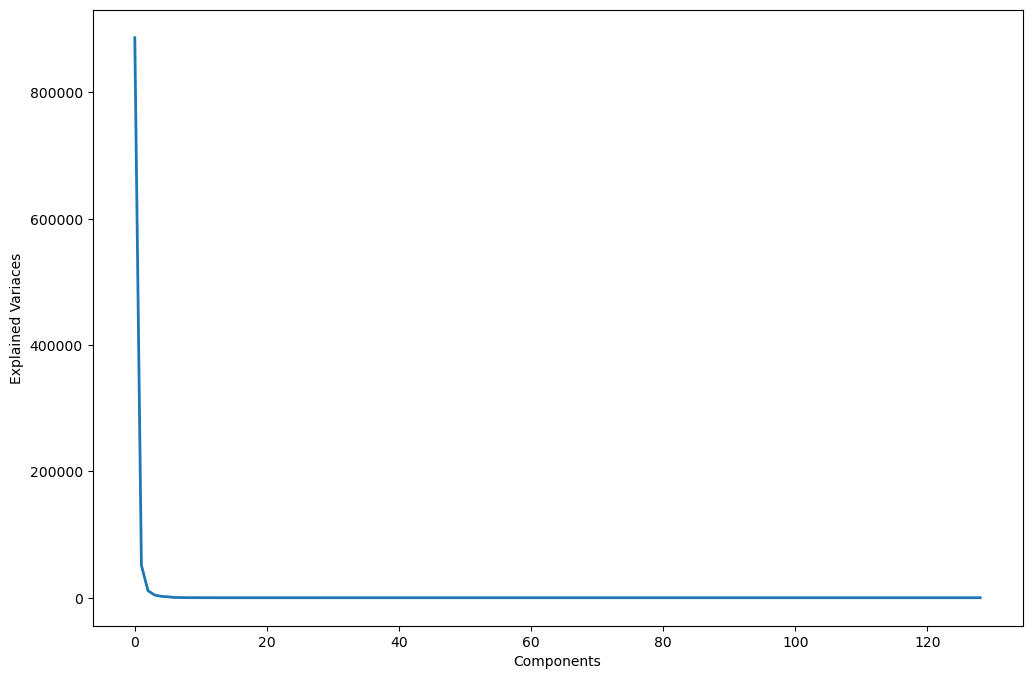

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca=PCA()
pca.fit(trainData)

plt.figure(1, figsize=(12,8))
plt.plot(pca.explained_variance_, linewidth=2)
plt.xlabel('Components')
plt.ylabel('Explained Variaces')
plt.show()